## Safiya Rehmat 18200494 
Connectionist Computing Programming Assignment

## Inroduction
This notebook implements networks to perform 3 different tasks:
    1. Train a network to learn XOR 
    2. Train a network to learn sin(x1-x2+x3-x4) for inputs x1,x2,x3 and x4 
    3. Train a network to perform letter recognition 


In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

## Network Architecture 
The figure below shows the architecture of networks used in this assignment:
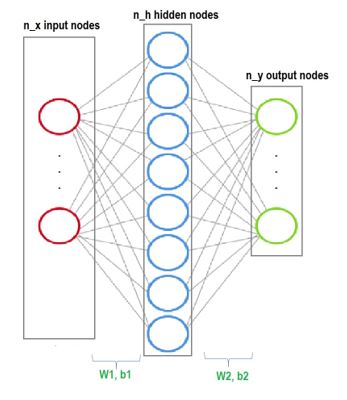

n_x and n_y are determined by the shape of the input and target outputs. n_h is a hyperparameter, with default value 3.

For tasks 1 and 2, we have only 1 output unit as they are regression tasks. Task 3 is a multi-class classification and thus has more than 1 output units.

In [2]:
def model_config(X, Y, hidden_units=3):

    n_x = X.shape[1]
    n_h = hidden_units
    n_y = Y.shape[1]
    
    assert(X.shape[0] == Y.shape[0])
    return (n_x, n_y, n_h)

In [3]:
# Model parameter initialisation
def init_model_parameters(n_x, n_y, n_h,regression):
    
    W1 = np.random.uniform(-0.2, 0.2,(n_x,n_h))
    b1 = np.random.uniform(-0.2,0.2,size=(1,n_h))
    W2 = np.random.uniform(-0.2,0.2,(n_h,n_y))
    b2 = np.random.uniform(-0.2,0.2,size=(1,n_y))


    assert(W1.shape == (n_x, n_h))
    assert(b1.shape == (1, n_h))
    assert(W2.shape == (n_h, n_y))
    assert(b2.shape == (1, n_y))
    
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2,"regression":regression}

## Forward Propogation 

<ul>

<li>In case of regression problems, we use tanh units for both hidden and output layers. The loss is calculated using mean squared error formula. </li>

<li>In case of multi-class classification, we use tanh for hidden units and softmax for output layer. The loss is computed as the cross entropy loss. </li>

</ul>

In [4]:
# for output layer in case of multi-class classification
def softmax(x):
    n = x.shape[0]
    exps = np.exp(x)
    p = exps / np.reshape(np.sum(exps,axis=1),(n,1))
    return p

def softmax_derivative(x):
    return softmax(x) * (1 - softmax(x))

# for hidden layer and ouput layer in case of regression
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

In [5]:
# Forward propagation (inference)
def forward_prop(params, X, Y=None):
    
    n = X.shape[0]

    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    regression = params["regression"]
  
    Z1 = np.dot(X, W1) + b1
    A1 = tanh(Z1)
    Z2 = np.dot(A1, W2) + b2
    if regression:
        A2 = tanh(Z2)
    else:
        A2 = softmax(Z2)

    n_x = params["W1"].shape[0]
    n_y = params["W2"].shape[1]
    n_h = params["W1"].shape[1]
    assert(A1.shape == (n, n_h))
    assert(Z1.shape == (n, n_h))
    assert(A2.shape == (n, n_y))
    assert(Z2.shape == (n, n_y))
    
    ## calculate loss 
    loss = float('nan')
    if Y is not None:
        if(regression):
            loss = 0.25* ((Y - A2)**2).mean() ## formula for MSD 
        else:
            loss = -(Y*np.log(A2)).mean()  ## formula for cross-entropy

        loss = np.squeeze(loss)
        assert(loss.dtype == float)
        
    return {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}, loss

## Backpropogation

In [6]:
# Backward_propagation
def back_prop(params, X, Y, cache):
   
    n = X.shape[0]
    W1 = params["W1"]
    W2 = params["W2"]   
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    regression = params["regression"]
    
    error = A2 - Y 
    if regression:
        d_Z2 = error * tanh_derivative(Z2)
    else: 
        d_Z2 = error
    dW2 = (A1.T @ d_Z2)/n
    
    error_hidden_layer =  d_Z2 @ W2.T 
    d_Z1 = error_hidden_layer * tanh_derivative(Z1)
    dW1 = (X.T @ d_Z1)/n
    
    db2 = np.sum(d_Z2, axis=0, keepdims=True) /n
    db1 = np.sum(d_Z1, axis=0, keepdims=True) /n
        
    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

In [7]:
# Update model parameters
def update_params(params, grads, learning_rate=0.8):
   
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    regression = params["regression"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
        
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "regression": regression}

In [8]:
def model_fit(params, X, Y, epochs=2000, learning_rate=0.8, verbose=False):
   
    n = X.shape[0]
    loss_log = []
    for i in range(epochs):
        cache, loss = forward_prop(params,X,Y)
        grads = back_prop(params, X, Y, cache)
        params = update_params(params, grads)
        
        # logs
        if i % 1000 == 0:
            loss_log.append(np.asscalar(loss))
            if verbose:
                print("Loss after {} iterations: {:.3f}".format(i, loss))
     
    return params, grads, loss_log

In [9]:
# Model inference
def model_predict(params, X):
    
    cache, loss = forward_prop(params,X)
    
    n = X.shape[0]   
    return cache["A2"]

In [10]:
#  get accuracy for training and test sets 
def get_softmax_accuracy(target,predicted):
    target_letter = np.argmax(target,axis=1)
    predicted_letter = np.argmax(predicted,axis=1)
    acc = 0
    n = target_letter.shape[0]
    for i in range(target_letter.shape[0]):
        #print("target = "+str(target_letter[i])+"    predicted = "+str(predicted_letter[i]))
        if(target_letter[i]==predicted_letter[i]):
            acc+=1
    acc = acc*100/n
    return acc
def get_regression_accuracy(target,predicted):
    acc = 100 * (1- np.mean(np.abs(target - predicted))/2)
    return acc 

## Get_Model ():
This is the main method that creates the model and measures accuracy for training and test set. It calls all the functions defined above. 

In [11]:
# get model for given training dataset. Main method which calls all the functions defined above. 
def get_model(X_train, Y_train, X_test, Y_test, hidden_units=3, epochs=10000, learning_rate=0.5,regression = True,):
    #get the number of units in each layer 
    (n_x, n_y, n_h) = model_config(X_train, Y_train, hidden_units)
    #initialize parameters
    params = init_model_parameters(n_x, n_y, n_h,regression)
    #fit the model
    params, grads, loss = model_fit(params, X_train, Y_train, epochs,learning_rate, verbose=True)
    #make predictions on training set 
    Y_hat_train = model_predict(params, X_train)
    #make predictions on test set
    Y_hat_test = model_predict(params, X_test)
    
    #get accuracy measure
    if(regression):
        train_acc = get_regression_accuracy(Y_train,Y_hat_train)
        test_acc = get_regression_accuracy(Y_test,Y_hat_test)
    else:
        train_acc = get_softmax_accuracy(Y_train,Y_hat_train)
        test_acc = get_softmax_accuracy(Y_test,Y_hat_test)

    print("{:.1f}% training acc.".format(train_acc))
    print("{:.1f}% test acc.".format(test_acc))
        
    return {"PARAMS": params, "LOSS": loss, "GRADS": grads, "ACC": [train_acc, test_acc], "LR": learning_rate,
            "y_hat_train":Y_hat_train, "y_hat_test":Y_hat_test}

## Task 1 - Learning the XOR function 

In [12]:
x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])
model = get_model(x,y,x,y,2,2300,0.1)

Loss after 0 iterations: 0.095
Loss after 1000 iterations: 0.000
Loss after 2000 iterations: 0.000
99.5% training acc.
99.5% test acc.


## Task 2 - Learning the sine function 

In [13]:
# create the input and targets for this task 
x = np.random.uniform(-1,1,(200,4))
y = []
for i in range(200):
    y.append( [math.sin( x[i,0]-x[i,1]+x[i,2]-x[i,3]) ] )
    
y = np.array(y)
y = np.reshape(y,(200,1))


In [14]:
x_train = x[0:150,:]
y_train = y[0:150]
x_test = x[150:200,:]
y_test = y[150:200]

model = get_model(x_train,y_train,x_test,y_test,10,15000,0.1)

Loss after 0 iterations: 0.114
Loss after 1000 iterations: 0.005
Loss after 2000 iterations: 0.005
Loss after 3000 iterations: 0.003
Loss after 4000 iterations: 0.004
Loss after 5000 iterations: 0.003
Loss after 6000 iterations: 0.002
Loss after 7000 iterations: 0.002
Loss after 8000 iterations: 0.002
Loss after 9000 iterations: 0.002
Loss after 10000 iterations: 0.002
Loss after 11000 iterations: 0.002
Loss after 12000 iterations: 0.002
Loss after 13000 iterations: 0.002
Loss after 14000 iterations: 0.002
96.7% training acc.
94.8% test acc.


## Task 3 - Learning Letter Recognition 

In [15]:
import warnings
warnings.filterwarnings('ignore')

import csv

dataset = list()
# Read data from csv
with open('data/letter-recognition.csv', newline='') as data_file:
    reader = csv.reader(data_file, delimiter=',')
    for row in reader:
        # Map the character to the integer number
        row[0] = ord(row[0]) - ord('A')
        dataset.append(row)

# Define a ratio to split the training test and test set
training_split = int(len(dataset) * 0.8)
# Split the training set
training_set = np.array(dataset[:training_split], dtype=np.int)
X = training_set[:, 1:]
y = training_set[:, 0]

# Define the number of output labels
num_labels = 26

# One hot encode y labels
categorical_y = np.zeros((len(y), num_labels))
for i, l in enumerate(y):
    categorical_y[i][l] = 1

# Split the inputs and outputs of the test set
test_set = np.array(dataset[training_split:], dtype=np.int)
test_x = test_set[:, 1:]
test_y = test_set[:, 0]

categorical_test_y = np.zeros((len(test_y), num_labels))
for i, l in enumerate(test_y):
    categorical_test_y[i][l] = 1


In [16]:
# Normalize the inputs 
X = X/np.max(X)
test_x = test_x / np.max(test_x)

model = get_model(X,categorical_y,test_x,categorical_test_y,30,8001,0.1,False)


Loss after 0 iterations: 0.126
Loss after 1000 iterations: 0.034
Loss after 2000 iterations: 0.027
Loss after 3000 iterations: 0.022
Loss after 4000 iterations: 0.020
Loss after 5000 iterations: 0.018
Loss after 6000 iterations: 0.016
Loss after 7000 iterations: 0.015
Loss after 8000 iterations: 0.014
89.4% training acc.
87.5% test acc.


## Conclusion

The performance of the model presented in this assignment is as follows for each task: 

### Task 1 : Learning the XOR function
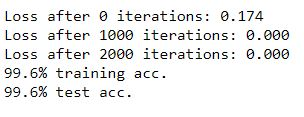

### Task 2 : Learning the Sine function
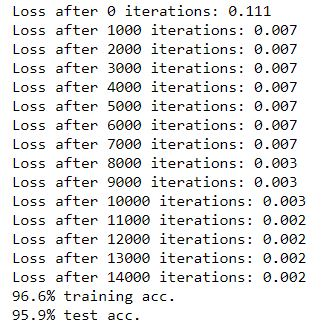

### Task 3 : Learning Letter Recognition
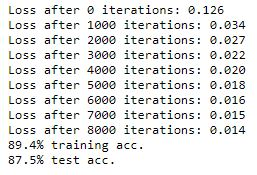

<ul>
    <li>We get 95% or above accuracy in the first 2 tasks on the test set, the model has learned these tasks pretty well.</li>
    <li>For task 3, we get 87.5% accuracy, which is pretty decent. We may be able to optimize it further by experimenting with the hyper-parameters </li> 
</ul>